In [16]:
#Etape 1 : Charger la séquence à partir du fichier FASTA
def lire_sequence_fasta(nom_fichier):
    """Lit une séquence FASTA (ignore la première ligne de description)"""
    sequence = ""
    with open(nom_fichier, 'r') as fichier:
        #lit la première ligne et l'ignore
        fichier.readline()
        ligne = fichier.readline()
        while ligne:
            sequence += ligne.strip()  #enlever les espaces et les sauts de ligne
            ligne = fichier.readline()  #lire la ligne suivante
    return sequence.upper()

In [17]:
#Etape 2 : Rechercher les régions riches en A et T
def calcul_régions_AT(sequence):
    """Renvoie les régions riches en A/T en comparant le nombre de G/C au nombre de A/T dans une région"""
    taille_région = 300
    régions_dintérêt = []
    
    for i in range(0, len(sequence) - taille_région + 1, taille_région):
        region = sequence[i:i+taille_région]
        cpt_AT = 0
        cpt_CG = 0
        for base in region:
            if base == 'A' or base == 'T':
                cpt_AT += 1
            elif base == 'C' or base == 'G':
                cpt_CG += 1
        if cpt_AT >= cpt_CG:
            régions_dintérêt.append((i, i + taille_région, region)) #récupère les positions de début et de fin de région + la région

    return régions_dintérêt


In [20]:
#Etape 3 : Détecter les motifs DnaA
import re

def motifs_consensus(regions):
    motifs = [
        r"TTATCCACA", r"TTGTCCACA", r"TTATGCACA", r"TTATCCAGA", r"TTATTCACA",
        r"TTATCCAAA", r"TCATTCACA", r"TCATTGACA", r"TTGTGCACA", r"ATATTTAAA"
    ]
    résultats = []
    for debut, fin, region in regions: #on cherche des motifs dans les séquences riches en AT
        for motif in motifs: 
            for match in re.finditer(motif, region): #extraire et localiser les motifs
                position_globale = debut + match.start()  #calcul de la position dans la séquence globale
                motif_trouvé = match.group() #motif trouvé dans la région
                résultats.append((position_globale, motif_trouvé))

    return résultats

Motifs DnaA trouvés : [(17169, 'TTATCCAAA'), (130990, 'TTGTGCACA'), (131391, 'TTATTCACA'), (136614, 'TTATTCACA')]


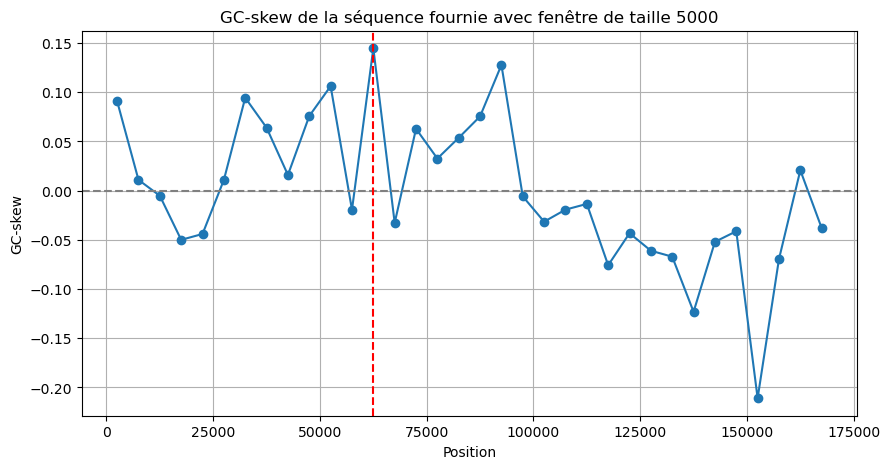

OriC détecté à la position(s) : [62500]


In [24]:
import matplotlib.pyplot as plt
#GC-skew 

def GC_skew(seq):
    """ Fonction qui calcule le GC-skew d'une séquence"""
    C = seq.count('C')
    G = seq.count('G')
    
    somme = G+C

    if somme == 0: 
        return 0 #Pour éviter de faire une division par 0
     
    return (G-C) / somme 

def GCskewfenetre (seq, fenetre):
    """Fonction qui calcule l'asymétrie GC dans une fenêtre"""
    sequences = [ ]
    position = [ ]
    for i in range (0, len(seq) - fenetre + 1 , fenetre): 
        seq_fenetre = seq[i:i+fenetre]
        val = GC_skew(seq_fenetre)
        sequences.append(val)
        position.append(i + fenetre//2) #Pour placer chaque valeur de GC_skew au milieu de sa fenêtre (pour mieux visualiser sur le graphe)
    return position, sequences

# Fonction pour détecter l'OriC basé sur le GC-skew
def detect_oriC(positions, sequences, seuil=0.1):
    """Détecte l'oriC en cherchant un changement de signe dans le GC-skew."""
    oriC_positions = []
    for i in range(1, len(sequences)):
        if abs(sequences[i] - sequences[i-1]) > seuil and sequences[i-1] < 0 and sequences[i] > 0:  # Passage de négatif à positif
            oriC_positions.append(positions[i])  # Enregistre la position du changement
    return oriC_positions

# ================= Programme principal =================

# Étape 1 : Lire la séquence
seq = lire_sequence_fasta('seqprojet.txt')

# Étape 2 : Détecter les régions riches en AT
regions = calcul_régions_AT(seq)

# Étape 3 : Détecter les motifs DnaA dans toute la séquence (comme ta fonction les cherche dans toute la séquence)
motifs = motifs_consensus(regions)
print("Motifs DnaA trouvés :", motifs)

# Étape 4 : Calculer le GC-skew
fenetre = 5000  # Taille de la fenêtre pour le calcul du GC-skew
pos_gc, val_gc = GCskewfenetre(seq, fenetre)

# Filtrer les OriC détectés
oriC_pos = detect_oriC(pos_gc, val_gc)

# Partie affichage du graphe
plt.figure(figsize=(10, 5))
plt.plot(pos_gc, val_gc, marker='o')
plt.title("GC-skew de la séquence fournie avec fenêtre de taille " + str(fenetre))
plt.xlabel("Position")
plt.ylabel("GC-skew")
plt.axhline(0, color='gray', linestyle='--')  # tracer une ligne horizontale à y = 0 pour visualiser où le GC-skew change de signe

# Marquer les positions de l'OriC détectées sur le graphique
for i in oriC_pos:
    plt.axvline(x=i, color='red', linestyle='--')

plt.grid(True)
plt.show()

# Affichage des positions des OriC filtrées
if oriC_pos:
    print(f"OriC détecté à la position(s) : {oriC_pos}")
else:
    print("Aucun OriC détecté.")